## About Dataset

| Column Name  | Description  |
| :------------: | :------------: |
| step  | represents a unit of time where 1 step equals 1 hour  |
| type  |  type of online transaction  |
| amount  | the amount of the transaction  |
| nameOrig  | customer starting the transaction  |
| oldbalanceOrg  | balance before the transaction  |
| newbalanceOrig  | balance after the transaction  |
| nameDest  | recipient of the transaction  |
| oldbalanceDest  | initial balance of recipient before the transaction  |
| newbalanceDest  | the new balance of recipient after the transaction  |
| isFraud  | fraud transaction  |


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential

## Helper Functions

In [2]:
def generate_colors(num):
    colors = []
    lst = list('ABCDEF0123456789')

    for i in range(num):
        colors.append('#'+''.join(np.random.choice(lst, 6)))
        
    return colors

# ----------------------------------------------------------------------
def missing_percentage(dataframe):
    """
    This function return take data frame and return data frame 
    with columns name, the number of missing values and the percentage 
    of them in each column.
    """
    total_missing = dataframe.isnull().sum().sort_values(ascending=False)
    missing_values = total_missing[total_missing.values !=0]
    missing_cols = missing_values.index
    
    missing_cols = dataframe[missing_cols].dtypes.values

    per = round((missing_values/len(dataframe))*100, 2)
    missing_df = pd.DataFrame(missing_values, columns=['Number of missing values'])
    
    return missing_df.assign(Percentage=per, Dtype=missing_cols)
#-----------------------------------------------------------------------------
def show_distribution(dataframe, col):
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    colors = generate_colors(1)
    
    sns.boxplot(data=dataframe, x=col, ax=ax[0], palette=colors)
    ax[0].set_title(f'{col.title()} Boxplot')
    
    sns.histplot(data=dataframe, x=col, ax=ax[1], color=colors, kde=True)
    ax[1].set_title(f'{col.title()} Histogram')
    
    fig.suptitle(f'{col.title()} Distribution'.replace('_', ' '), fontsize=15, color='brown')
#-----------------------------------------------------------------------------------
def show_outliers_accordingTo_target(data_frame, numeric_cols, target_col):
    plt.figure(figsize=(20, 15))
    for i in range(len(numeric_cols)):
        plt.subplot(8,4, i+1)
        sns.scatterplot(data=data_frame, x=numeric_cols[i], y=target_col, color=generate_colors(1))
        plt.title(f'{numeric_cols[i].title()} According to the Target')
        plt.subplots_adjust(hspace=0.9, wspace=0.4)

In [46]:
data = pd.read_csv('../input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [48]:
missing_percentage(data)

,Number of missing values,Percentage,Dtype


> We don't have any missing values in our data

In [49]:
obj_cols = data.select_dtypes(include='object').columns
obj_cols

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [50]:
for i in obj_cols:
    print(f'Number of unique values in {i} : {data[i].nunique()}')
    print(f'Unique Value {i}\n:{data[i].unique()}\n')
    print(data[i].value_counts())
    print('----------------------------------------------')

Number of unique values in type : 5
Unique Value type
:['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
----------------------------------------------
Number of unique values in nameOrig : 6353307
Unique Value nameOrig
:['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64
----------------------------------------------
Number of unique values in nameDest : 2722362
Unique Value nameDest
:['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470

- Notes:
    - The types of online transaction which is most frequent is cash-out/cash-in/payment
    - In nameDest & nameOrg columns, we can replace the values which occure one time or more to (others) to make data more simple or drop these columns.
    
    
> Let's show the distribution for the numeric columns

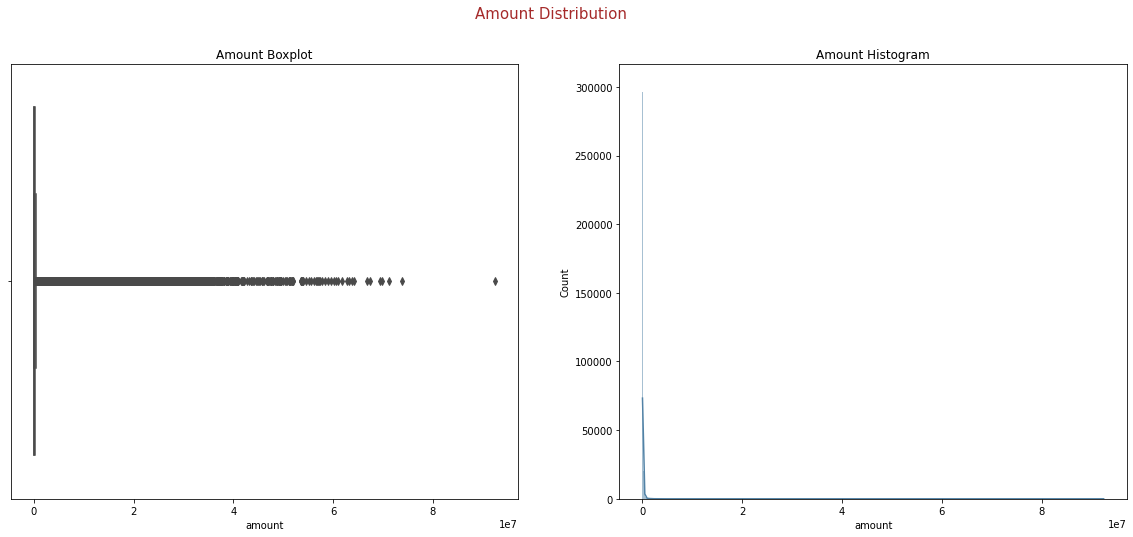

In [51]:
show_distribution(data, 'amount')

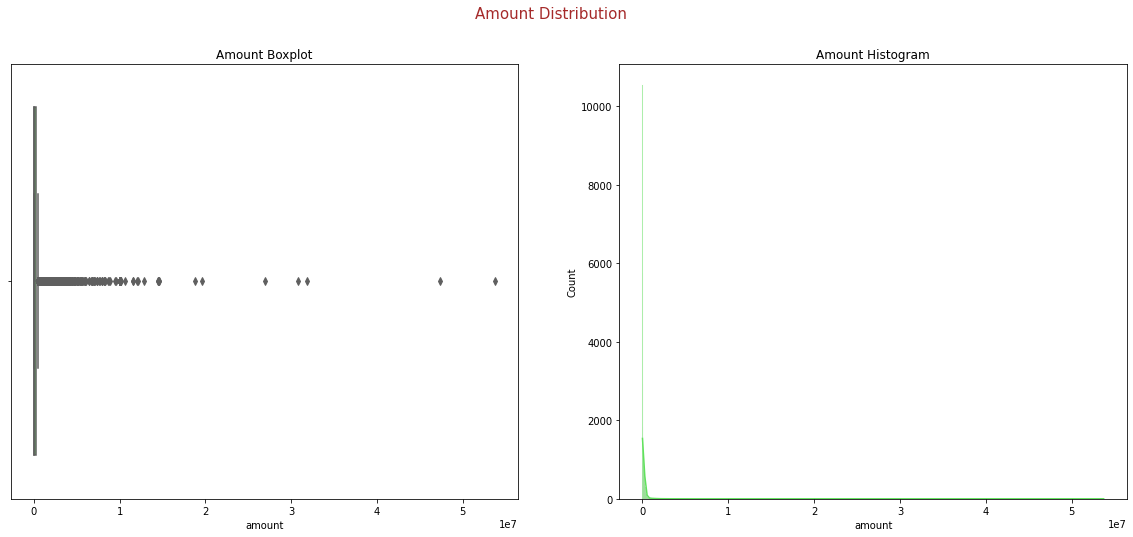

In [52]:
show_distribution(data.sample(50000), 'amount')

> We can observe that the data size is over 6 million records. when we take a sample from data and see the distribution, It's have the same distribution for the full data which is 6 million records. **So I will see the distribution from sample data**

In [53]:
num_cols = data.select_dtypes(exclude='object').columns
num_cols

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

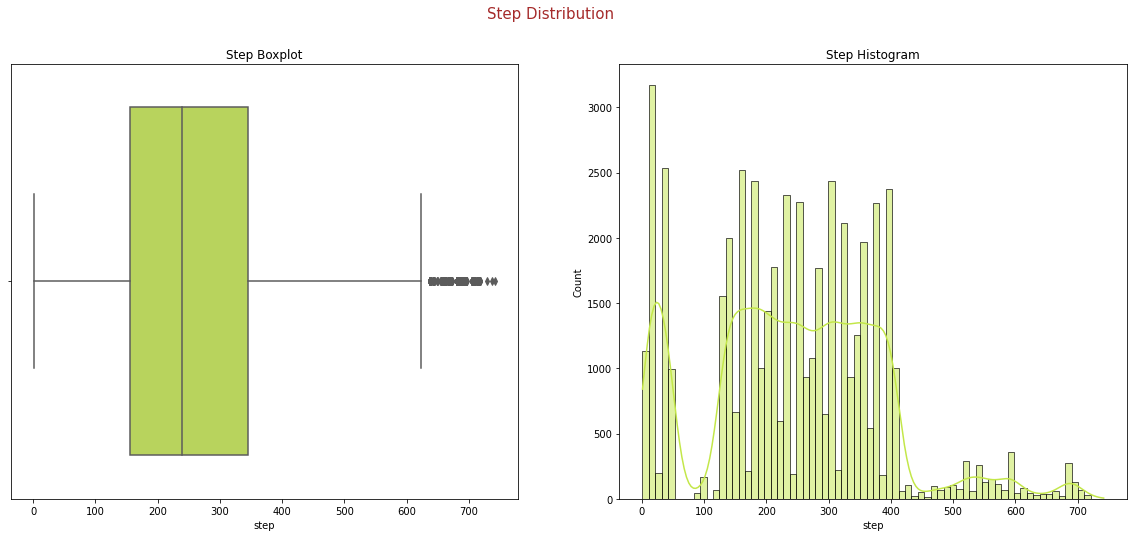

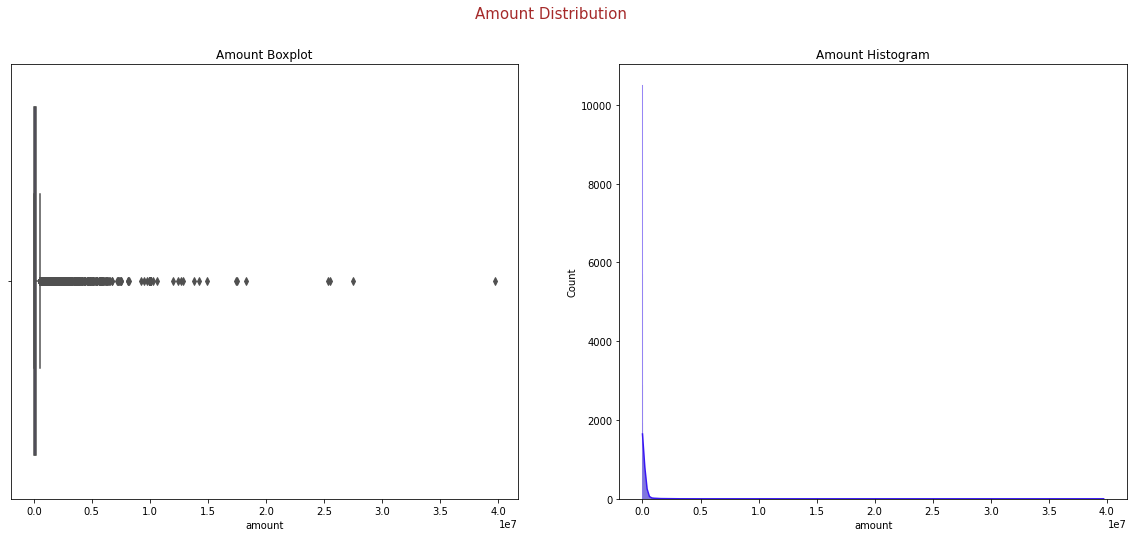

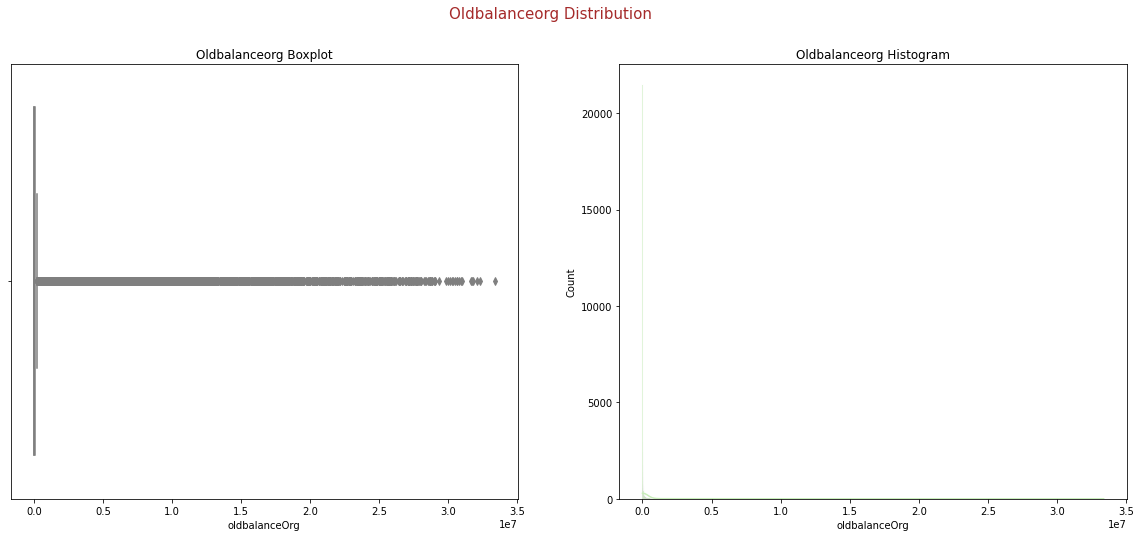

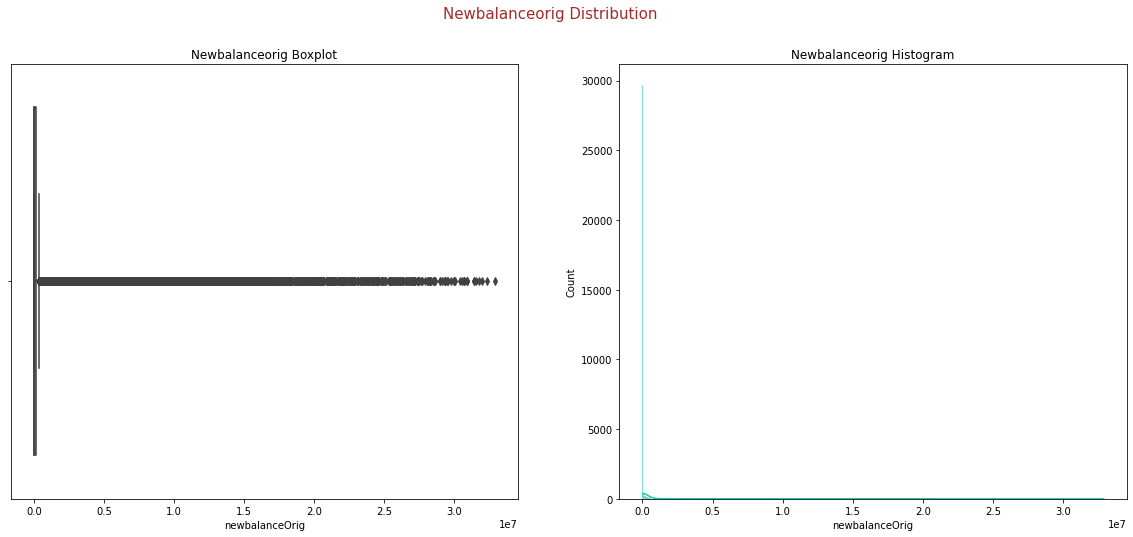

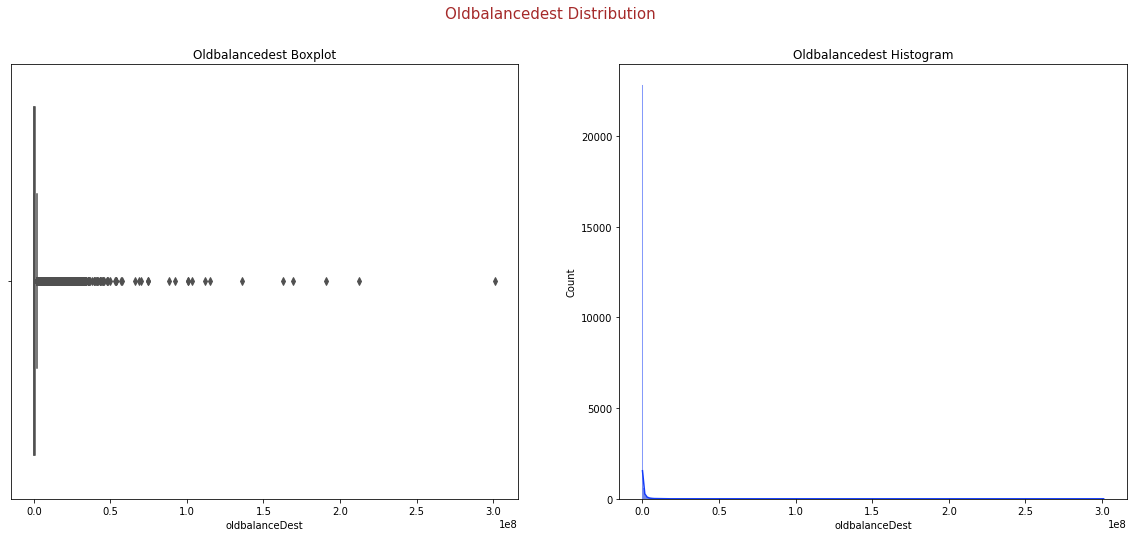

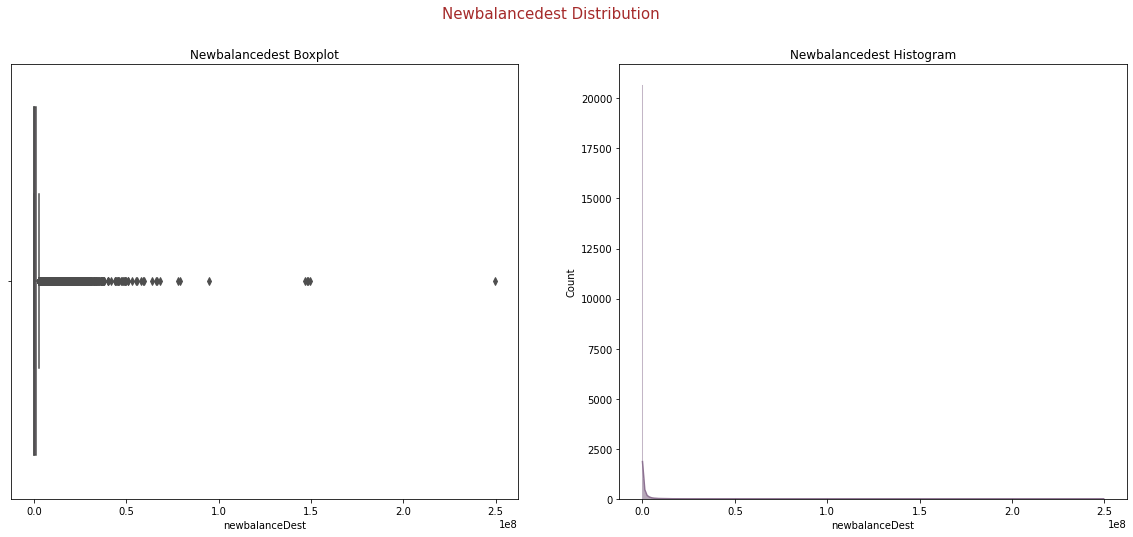

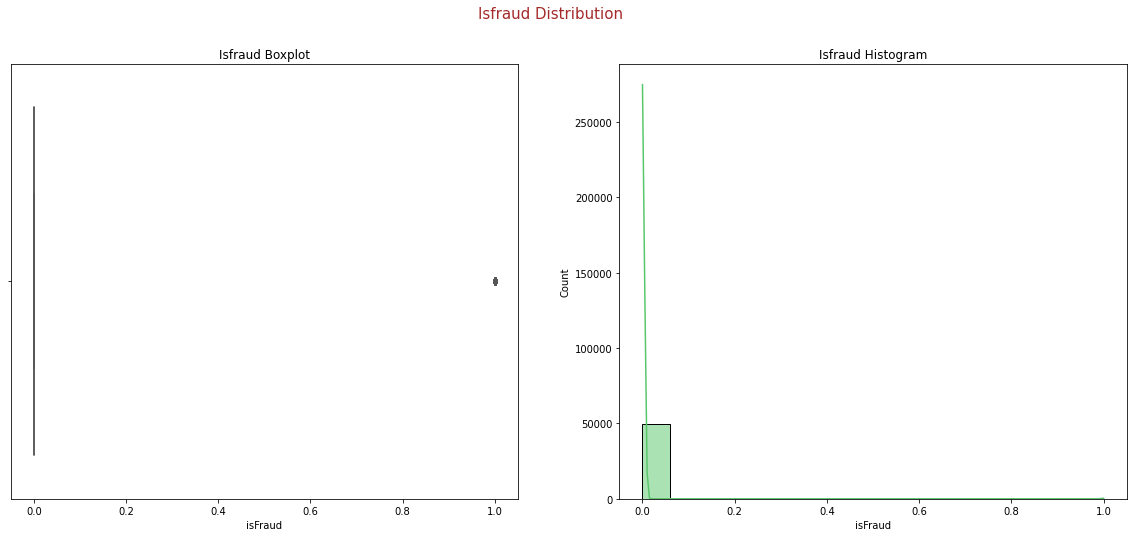

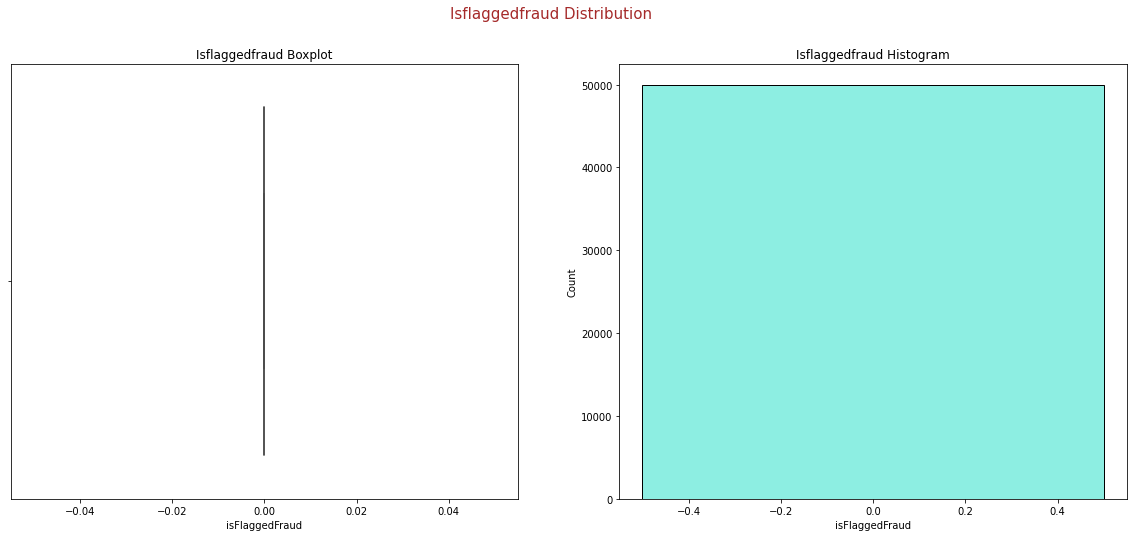

In [54]:
for i in num_cols:
    show_distribution(data.sample(50000), i)

In [55]:
data['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [56]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The data has many outliers and the distribution is skewed

> Steps I will do to reduce the number of features:<br></br>
    - delete 4 columns which are **oldbalanceOrg, newbalanceOrg, oldbalanceDest, newbalanceDest, nameOrig, nameDest** and add 2 colums which are the different between them.

In [5]:
data['diffOrg'] = data['oldbalanceOrg']-data['newbalanceOrig']
data['diffDest'] = data['oldbalanceDest'] - data['newbalanceDest']

In [6]:
data = data.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'nameOrig', 'nameDest'], axis=1)

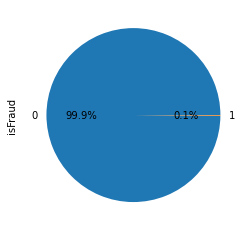

In [7]:
data['isFraud'].value_counts().plot.pie(autopct='%1.1f%%');

The problem now is the data is unbalanced. So we need to deal with that with oversampling techinques

In [8]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
print(f'Train data shape : {train_data.shape}') 
print(f'Test data shape : {test_data.shape}')

Train data shape : (4453834, 7)
Test data shape : (1908786, 7)


In [9]:
x = train_data.drop('isFraud', axis=1)
y = train_data['isFraud']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

In [10]:
x_train.sample(8)

,step,type,amount,isFlaggedFraud,diffOrg,diffDest
4511963,325,CASH_IN,510638.50,0,-510638.50,0.00
4468620,324,CASH_OUT,395763.74,0,0.00,-395763.74
5842741,402,PAYMENT,14004.66,0,9310.86,0.00
2935508,229,PAYMENT,9555.29,0,0.00,0.00
5543661,382,PAYMENT,4308.56,0,4308.56,0.00
3711277,277,CASH_OUT,195629.35,0,195629.35,-195629.35
4328451,308,PAYMENT,5736.38,0,5736.38,0.00
103278,10,PAYMENT,10692.83,0,0.00,0.00


**Next Steps**:
- using robust scaler
- use laber encoder

In [11]:
le = LabelEncoder()
x_train['type'] = le.fit_transform(x_train['type'])
x_valid['type'] = le.transform(x_valid['type'])

x_train.sample(4)

,step,type,amount,isFlaggedFraud,diffOrg,diffDest
6312228,686,0,336962.22,0,-336962.22,336962.22
5513466,380,3,40117.19,0,0.00,0.00
5712560,398,0,4050.16,0,-4050.16,4050.16
624706,34,4,618527.53,0,421.00,-265374.14


In [12]:
rs = RobustScaler()
x_train = rs.fit_transform(x_train)
x_valid = rs.transform(x_valid)

In [13]:
x_train[12]

array([-3.07262570e-01,  1.50000000e+00,  1.08382566e-03,  0.00000000e+00,
        0.00000000e+00, -5.04236990e-01])

In [14]:
# Let's apply SMOTE (over sampling technique) to make data balance
sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [15]:
x_train_res.shape

(6672114, 6)

In [28]:
model = Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#model.summary()

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [30]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', mode='min')
history = model.fit(x_train_res, y_train_res, epochs=20, steps_per_epoch=100000, validation_data=(x_valid, y_valid), callbacks=[callbacks])

Epoch 1/20
100000/100000 [==============================] - 323s 3ms/step - loss: 0.0558 - accuracy: 0.9773 - val_loss: 0.0538 - val_accuracy: 0.9666
Epoch 2/20
100000/100000 [==============================] - 282s 3ms/step - loss: 0.0485 - accuracy: 0.9804 - val_loss: 0.0658 - val_accuracy: 0.9673
Epoch 3/20
100000/100000 [==============================] - 281s 3ms/step - loss: 0.0468 - accuracy: 0.9811 - val_loss: 0.0536 - val_accuracy: 0.9673
Epoch 4/20
100000/100000 [==============================] - 282s 3ms/step - loss: 0.0462 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9701
Epoch 5/20
100000/100000 [==============================] - 282s 3ms/step - loss: 0.0454 - accuracy: 0.9819 - val_loss: 0.0567 - val_accuracy: 0.9690
Epoch 6/20
100000/100000 [==============================] - 282s 3ms/step - loss: 0.0447 - accuracy: 0.9822 - val_loss: 0.0576 - val_accuracy: 0.9690
Epoch 7/20
100000/100000 [==============================] - 320s 3ms/step - loss: 0.0444 - accuracy:

In [22]:
test_data.sample(6)

,step,type,amount,isFraud,isFlaggedFraud,diffOrg,diffDest
2382878,201,CASH_IN,268634.32,0,0,-268634.32,193893.23
2004382,179,TRANSFER,1129048.83,0,0,0.00,-1129048.83
3111016,235,CASH_OUT,474852.99,0,0,0.00,-474852.99
5030662,354,CASH_OUT,94271.48,0,0,94271.48,-94271.48
4494126,325,CASH_OUT,278478.18,0,0,115395.00,-278478.18
4494598,325,PAYMENT,34585.27,0,0,0.00,0.00


In [23]:
x_test = test_data.drop('isFraud', axis=1)
y_test = test_data['isFraud']

x_test['type'] = le.transform(x_test['type'])
x_test = rs.transform(x_test)

In [24]:
x_test[12]

array([-0.15642458,  0.        ,  0.40238825,  0.        ,  2.01773749,
       -1.02966379])

In [31]:
model.evaluate(x_valid, y_valid)

34796/34796 [==============================] - 58s 2ms/step - loss: 0.0550 - accuracy: 0.9699


[0.05497144162654877, 0.9699360132217407]

In [32]:
model.evaluate(x_test, y_test)

59650/59650 [==============================] - 99s 2ms/step - loss: 0.0555 - accuracy: 0.9702


[0.0554625578224659, 0.9701946973800659]

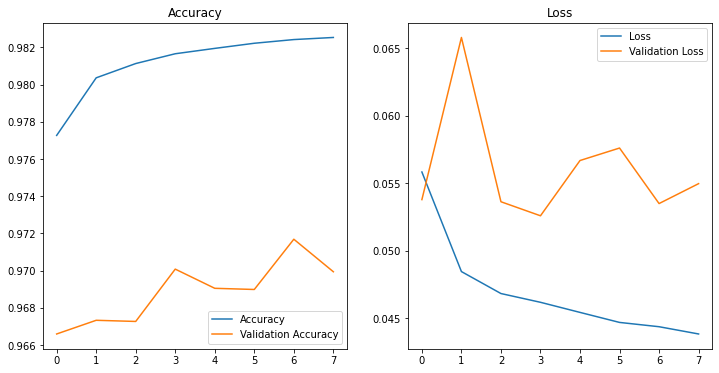

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(len(acc)), acc, label='Accuracy');
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy');
plt.title('Accuracy')
plt.legend();

plt.subplot(122)
plt.plot(range(len(loss)), loss, label='Loss');
plt.plot(range(len(loss)), val_loss, label='Validation Loss');
plt.title('Loss')
plt.legend();


In [34]:
y_pred = model.predict(x_test)

In [35]:
y_pred[:5]

array([[0.0000000e+00],
       [1.3619806e-13],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [36]:
y_pred[y_pred==1]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [37]:
y_pred.shape

(1908786, 1)

In [38]:
y_pred[10]

array([0.], dtype=float32)

In [39]:
print(classification_report(y_test, y_pred.astype('int')))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.99      0.46      0.63      2435

    accuracy                           1.00   1908786
   macro avg       1.00      0.73      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



> We can observe that there is an overfitting problem

In [16]:
# Let's Try another model
model = Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#model.summary()

2022-10-15 11:40:08.009940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 11:40:08.105683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 11:40:08.106545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 11:40:08.108295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [18]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', mode='min')
history = model.fit(x_train_res, y_train_res, epochs=20, steps_per_epoch=100000, validation_data=(x_valid, y_valid), callbacks=[callbacks])

2022-10-15 11:40:15.565394: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
100000/100000 [==============================] - 322s 3ms/step - loss: 0.0554 - accuracy: 0.9776 - val_loss: 0.0601 - val_accuracy: 0.9646
Epoch 2/20
100000/100000 [==============================] - 318s 3ms/step - loss: 0.0486 - accuracy: 0.9802 - val_loss: 0.0670 - val_accuracy: 0.9652
Epoch 3/20
100000/100000 [==============================] - 280s 3ms/step - loss: 0.0469 - accuracy: 0.9809 - val_loss: 0.0560 - val_accuracy: 0.9686
Epoch 4/20
100000/100000 [==============================] - 279s 3ms/step - loss: 0.0459 - accuracy: 0.9814 - val_loss: 0.0563 - val_accuracy: 0.9679
Epoch 5/20
100000/100000 [==============================] - 279s 3ms/step - loss: 0.0450 - accuracy: 0.9819 - val_loss: 0.0581 - val_accuracy: 0.9689
Epoch 6/20
100000/100000 [==============================] - 279s 3ms/step - loss: 0.0444 - accuracy: 0.9823 - val_loss: 0.0573 - val_accuracy: 0.9683
Epoch 7/20
100000/100000 [==============================] - 280s 3ms/step - loss: 0.0439 - accuracy:

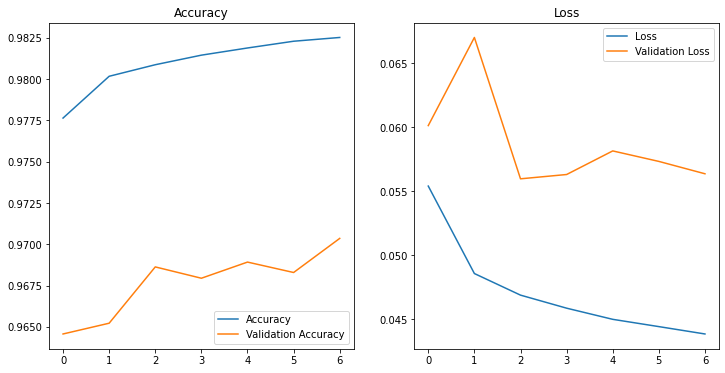

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(len(acc)), acc, label='Accuracy');
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy');
plt.title('Accuracy')
plt.legend();

plt.subplot(122)
plt.plot(range(len(loss)), loss, label='Loss');
plt.plot(range(len(loss)), val_loss, label='Validation Loss');
plt.title('Loss')
plt.legend();


In [25]:
model.evaluate(x_test, y_test)

59650/59650 [==============================] - 101s 2ms/step - loss: 0.0565 - accuracy: 0.9706


[0.05651075765490532, 0.9706096053123474]

In [21]:
model.evaluate(x_valid, y_valid)

34796/34796 [==============================] - 58s 2ms/step - loss: 0.0564 - accuracy: 0.9704


[0.05636034160852432, 0.9703563451766968]

In [26]:
y_pred = model.predict(x_test)

In [27]:
print(classification_report(y_test, y_pred.astype('int')))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.99      0.53      0.69      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.76      0.84   1908786
weighted avg       1.00      1.00      1.00   1908786

